# Set up

In [0]:
!pip install -U -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!echo '{"username":"aksonsam","key":"bf611cb9849cb706c0fd16c854cd9e21"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d moltean/fruits

 98% 679M/690M [00:15<00:00, 44.6MB/s]
100% 690M/690M [00:15<00:00, 47.3MB/s]


In [0]:
# !mkdir data
!unzip -d data -q fruits.zip

# Data

In [0]:
import glob

In [0]:
train_files = glob.glob('data/fruits-360/Training/*/*')
test_files = glob.glob('data/fruits-360/Test/*/*')

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
np.random.seed(0)
np.random.shuffle(train_files)
np.random.shuffle(test_files)

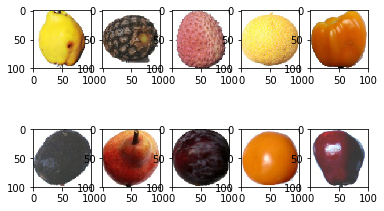

In [9]:
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(plt.imread(train_files[i]))
plt.show()

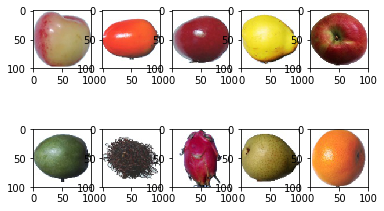

In [10]:
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(plt.imread(test_files[i]))
plt.show()

In [0]:
import torch
import torchvision

from torchvision import transforms

In [0]:
# data_transforms = {
#     'Training': transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'Test':transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }

train_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
])


test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])
])

train_set_fruits = torchvision.datasets.ImageFolder('data/fruits-360/Training', transform=train_trans)
test_set_fruits = torchvision.datasets.ImageFolder('data/fruits-360/Test', transform=test_trans)

In [48]:
train_size = int(0.9 * len(train_set_fruits))
test_size = len(train_set_fruits) - train_size

train_fruits_data, val_fruits_data = torch.utils.data.random_split(train_set_fruits, [train_size, test_size])

len(train_fruits_data), len(val_fruits_data)

(48664, 5408)

In [0]:
# data_dir = 'data/fruits-360'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Test']}

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['Training', 'Test']}

# class_names = image_datasets['Training'].classes

batch_size=128

train_fruit_loaders = torch.utils.data.DataLoader(train_fruits_data, batch_size=batch_size, shuffle=True)
val_fruit_loaders = torch.utils.data.DataLoader(val_fruits_data, batch_size=batch_size, shuffle=True)
test_fruit_loaders = torch.utils.data.DataLoader(test_set_fruits, batch_size=batch_size, shuffle=False)

class_names = train_set_fruits.classes

In [0]:
class_names = dict((i, v) for i, v in enumerate(train_set_fruits.classes))

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
def imshow(inp, title=None):
  """Imshow for tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

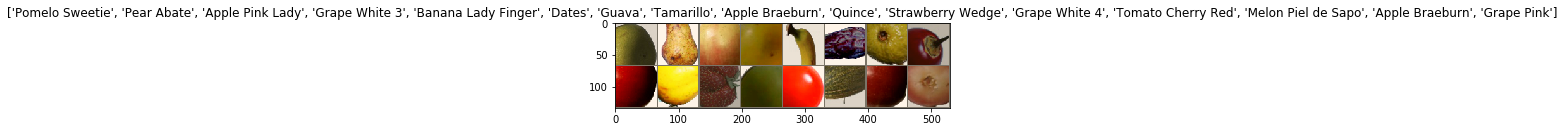

In [17]:
inputs, classes = next(iter(train_fruit_loaders))

# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x.item()] for x in classes])

In [52]:
inputs, classes = next(iter(train_fruit_loaders))
inputs.shape

torch.Size([128, 3, 100, 100])

# Training

## resnet model

In [0]:
def get_trainable(model_params):
  return (p for p in model_params if p.requires_grad)

def get_frozen(model_params):
  return (p for p in model_params if not p.requires_grad)

def all_trainable(model_params):
  return all(p.requires_grad for p in model_params)

def all_frozen(model_params):
  return all(not p.requires_grad for p in model_params)

def freeze_all(model_params):
  for param in model_params:
    param.requires_grad = False

In [0]:
from torchvision import models

In [53]:
n_classes = len(class_names)
n_classes

105

In [0]:
def get_model(n_classes):
  model = models.resnet18(pretrained=True)
  freeze_all(model.parameters())
  model.fc = torch.nn.Linear(512, n_classes)
  model = model.to(device)
  return model

In [0]:
resnet18_fruits_model = get_model(n_classes)

In [56]:
inputs.shape

torch.Size([128, 3, 100, 100])

In [57]:
import torchsummary

torchsummary.summary(resnet18_fruits_model, inputs.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

In [0]:
criterion = torch.nn.CrossEntropyLoss()

In [0]:
optimizer = torch.optim.Adam(get_trainable(resnet18_fruits_model.parameters()), lr=1e-3, weight_decay=1e-3//batch_size)

In [0]:
%matplotlib inline

In [0]:
from tqdm import tqdm_notebook as tqdm
import sys

In [0]:
def run_model1(n_epochs):
  """Function to run the model training loop."""
  for epoch in range(n_epochs):
    print('Epoch {} /{} ----'.format(epoch +1, n_epochs))
    print()

    resnet18_fruits_model.train()

    running_loss, correct = 0.0, 0
    with tqdm(total=len(train_fruit_loaders.dataset)//batch_size) as pbar:
      for i, data in enumerate(train_fruit_loaders, 0):
        pbar.set_description('Batches: %d  ' % (1 + i))
        pbar.update(1)
        # set_trace()
        img, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        y_ = resnet18_fruits_model(img)
        loss = criterion(y_, labels)
        loss.backward()
        optimizer.step()

        # statistics
        # print(f"batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(y_, 1)
        correct += (y_label_ == labels).sum().item()
        running_loss += loss.item() * img.shape[0]
      print(f" Train Loss: {running_loss/len(train_fruit_loaders.dataset)}")
      print(f" Train Acc : {correct / len(train_fruit_loaders.dataset)}")

    resnet18_fruits_model.eval()

    if epoch % 5 == 0:
      print('Checking on validation data ---')
      print('-'*10)
      running_loss, correct = 0.0, 0
      with tqdm(total=len(val_fruit_loaders.dataset)//batch_size, file=sys.stdout) as pbar:
        with torch.no_grad():
          for i, data in enumerate(val_fruit_loaders, 0):
            pbar.set_description('Validation Batches: %d  ' % (1 + i))
            pbar.update(1)
            x, y = data[0].to(device), data[1].to(device)
            y_ = resnet18_fruits_model(x)
            # statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * x.shape[0]
          print(f"Valid Loss: {running_loss/len(val_fruit_loaders.dataset)}")
          print(f"Valid Acc: {correct/len(val_fruit_loaders.dataset)}")
          print()

In [63]:
n_epochs = 20

run_model1(n_epochs)

Epoch 1 /20 ----



 Train Loss: 0.4246673547423495
 Train Acc : 0.9534358047016275

Checking on validation data ---
----------


Valid Loss: 0.10403592769916241
Valid Acc: 0.9938979289940828


Epoch 2 /20 ----



 Train Loss: 0.07813382939670248
 Train Acc : 0.9933626500082197

Epoch 3 /20 ----



 Train Loss: 0.04127176556342451
 Train Acc : 0.9971642281768864

Epoch 4 /20 ----



 Train Loss: 0.0279646073955661
 Train Acc : 0.9977190530987999

Epoch 5 /20 ----



 Train Loss: 0.020877683583292426
 Train Acc : 0.9985204668748973

Epoch 6 /20 ----



 Train Loss: 0.016379735319728663
 Train Acc : 0.9984588196613513

Checking on validation data ---
----------


Valid Loss: 0.009954034190999685
Valid Acc: 0.9994452662721893


Epoch 7 /20 ----



 Train Loss: 0.013014444648073081
 Train Acc : 0.9989314482985369

Epoch 8 /20 ----



 Train Loss: 0.010881823948877689
 Train Acc : 0.9989930955120828

Epoch 9 /20 ----



 Train Loss: 0.009805244895976055
 Train Acc : 0.9989108992273549

Epoch 10 /20 ----



 Train Loss: 0.00798630389992283
 Train Acc : 0.9991369390103567

Epoch 11 /20 ----



 Train Loss: 0.007125623884286101
 Train Acc : 0.9991780371527207

Checking on validation data ---
----------


Valid Loss: 0.005281491579829588
Valid Acc: 0.9996301775147929


Epoch 12 /20 ----



 Train Loss: 0.006787330337274791
 Train Acc : 0.9990752917968108

Epoch 13 /20 ----



 Train Loss: 0.0052591862067269115
 Train Acc : 0.9994246260069045

Epoch 14 /20 ----



 Train Loss: 0.005588134176321493
 Train Acc : 0.9991163899391747

Epoch 15 /20 ----



 Train Loss: 0.004345702212560706
 Train Acc : 0.9994451750780865

Epoch 16 /20 ----



 Train Loss: 0.004021077289321962
 Train Acc : 0.9995890185763604

Checking on validation data ---
----------


Valid Loss: 0.003474163846250557
Valid Acc: 0.9990754437869822


Epoch 17 /20 ----



 Train Loss: 0.0038627962631169756
 Train Acc : 0.9994657241492685

Epoch 18 /20 ----



 Train Loss: 0.003927005359974324
 Train Acc : 0.9993424297221766

Epoch 19 /20 ----



 Train Loss: 0.0035434905970880962
 Train Acc : 0.9995479204339964

Epoch 20 /20 ----



 Train Loss: 0.003942012847943568
 Train Acc : 0.9992396843662666



In [0]:
from sklearn.metrics import classification_report

In [0]:
for x, y in test_fruit_loaders:
  print(x.shape, y.shape)

In [70]:
y_preds = []
y_trues = []
with torch.no_grad():
  for x, y in test_fruit_loaders:
    x = x.to(device)
    y_pred = resnet18_fruits_model(x)
    y_pred = list(torch.argmax(y_pred, dim=1).cpu().numpy())
    y_true = list(y.numpy())
    y_preds.extend(y_pred)
    y_trues.extend(y_true)

print(classification_report(y_trues, y_preds, target_names=list(class_names.values())))
    

                     precision    recall  f1-score   support

     Apple Braeburn       0.85      0.99      0.92       164
 Apple Crimson Snow       1.00      1.00      1.00       148
     Apple Golden 1       1.00      0.99      1.00       164
     Apple Golden 2       1.00      0.97      0.98       164
     Apple Golden 3       0.82      1.00      0.90       161
 Apple Granny Smith       0.97      0.84      0.90       164
    Apple Pink Lady       0.98      1.00      0.99       152
        Apple Red 1       0.96      0.99      0.97       164
        Apple Red 2       0.96      0.85      0.90       164
        Apple Red 3       1.00      0.99      0.99       144
Apple Red Delicious       1.00      1.00      1.00       166
 Apple Red Yellow 1       1.00      1.00      1.00       164
 Apple Red Yellow 2       1.00      1.00      1.00       219
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe    